# Explainatory Data Analysis

In [4]:
# Import relevant libraries
import dask.dataframe as dd
from dask.distributed import Client

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [5]:
# Set up a dask cluster
client = Client(n_workers=3, threads_per_worker = 2, memory_limit='4G')
client

/home/yannik/anaconda3/envs/bigdata/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38299 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38299/status,
Dashboard: http://127.0.0.1:38299/status,Workers: 3
Total threads: 6,Total memory: 11.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46629,Workers: 3
Dashboard: http://127.0.0.1:38299/status,Total threads: 6
Started: Just now,Total memory: 11.18 GiB
Comm: tcp://127.0.0.1:36943,Total threads: 2
Dashboard: http://127.0.0.1:42559/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44015,


# DATA Prep

In [6]:
# Read in dataset
raw_df = dd.read_parquet("../data/processed/parking_violations_issued_2023.parquet")
raw_df

,summons_number,plate_id,registration_state,plate_type,issue_date,violation_code,vehicle_body_type,vehicle_make,issuing_agency,street_code1,street_code2,street_code3,vehicle_expiration_date,violation_location,violation_precinct,issuer_precinct,issuer_code,issuer_command,issuer_squad,violation_time,time_first_observed,violation_county,violation_in_front_of_or_opposite,house_number,street_name,intersecting_street,date_first_observed,law_section,sub_division,violation_legal_code,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,unregistered_vehicle?,vehicle_year,meter_number,feet_from_curb,violation_post_code,violation_description,no_standing_or_stopping_violation,hydrant_violation,double_parking_violation
npartitions=27,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int32,object,category[unknown],category[unknown],datetime64[ns],int16,object,object,category[unknown],int32,int32,int32,int32,object,int32,int32,int32,object,object,object,object,category[unknown],object,object,object,object,int32,int32,object,object,object,object,object,object,category[unknown],int16,object,int16,object,object,category[unknown],category[unknown],category[unknown]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
cols_to_keep =['registration_state',
                'plate_type',
                'issue_date',
                'violation_time',
                'violation_location',
                'violation_precinct',
                'issuer_precinct',
                'issuer_code',
                'violation_code',
                'meter_number',
                'violation_county',
                'issuer_squad',
                'issuing_agency',
                'vehicle_make',
                'street_name']

In [8]:
df = raw_df[cols_to_keep].copy()
#df.compute()

Correlations?

In [9]:
precinct_loc_df = df[['violation_location', 'violation_precinct', 'issuer_precinct']]
precinct_loc_df.corr().compute()

,violation_location,violation_precinct,issuer_precinct
violation_location,1.000000,1.000000,0.611055
violation_precinct,1.000000,1.000000,0.739477
issuer_precinct,0.611055,0.739477,1.000000


In [10]:
df = df.drop('violation_precinct', axis=1).compute()

In [11]:
df.head()

,registration_state,plate_type,issue_date,violation_time,violation_location,issuer_precinct,issuer_code,violation_code,meter_number,violation_county,issuer_squad,issuing_agency,vehicle_make,street_name
0,NY,PAS,2022-06-10,1037A,0010,1,160195,67,-,NY,0000,P,TOYOT,W 28TH ST
1,NY,PAS,2022-06-13,1045A,0010,1,160195,51,-,NY,0000,K,JEEP,27TH DR
2,NJ,PAS,2022-06-19,1116A,0001,1,161315,63,-,NY,0000,N,JEEP,SOUTH ST
3,NY,PAS,2022-06-19,1052A,0001,1,161315,63,-,NY,0000,N,LEXUS,SOUTH ST
4,NJ,PAS,2022-06-19,1107A,0001,1,161315,63,-,NY,0000,N,HYUND,SOUTH ST


In [12]:
print(list(df['violation_county'].unique()))

['NY', 'BX', 'Q', 'R', 'K', nan, 'MS', 'BK', 'QN', 'MN', 'Kings', 'Qns', 'Bronx', 'Rich', 'ST', 'QNS', 'ABX', 'QUEEN']


In [13]:
df['violation_county'].value_counts()

violation_county
NY       3104766
QN       2255203
BK       2093322
BX       1877156
K        1752203
Q        1567140
MN        725066
ST        400483
Kings     230699
R         124385
Bronx     122298
Qns        68410
Rich        1124
QUEEN          5
QNS            4
MS             1
ABX            1
Name: count, dtype: int64

In [14]:
remap_county_dict = {
    'NY': 'Manhattan',
    'QN': 'Queens',
    'BK': 'Brooklyn',
    'BX': 'Bronx',
    'K': 'Kings',
    'Q': 'Queens',
    'MN': 'Manhattan',
    'ST': 'Staten Island',
    'Kings': 'Brooklyn',
    'R': 'Staten Island',
    'Bronx': 'Bronx',
    'Qns': 'Queens',
    'Rich': 'Staten Island',
    'QUEEN': 'Queens',
    'QNS': 'Queens',
    'MS': 'Manhattan',
    'ABX': 'Bronx'
}

In [15]:

df['violation_county'] = df['violation_county'].map(remap_county_dict).astype('category')
df.head()

,registration_state,plate_type,issue_date,violation_time,violation_location,issuer_precinct,issuer_code,violation_code,meter_number,violation_county,issuer_squad,issuing_agency,vehicle_make,street_name
0,NY,PAS,2022-06-10,1037A,0010,1,160195,67,-,Manhattan,0000,P,TOYOT,W 28TH ST
1,NY,PAS,2022-06-13,1045A,0010,1,160195,51,-,Manhattan,0000,K,JEEP,27TH DR
2,NJ,PAS,2022-06-19,1116A,0001,1,161315,63,-,Manhattan,0000,N,JEEP,SOUTH ST
3,NY,PAS,2022-06-19,1052A,0001,1,161315,63,-,Manhattan,0000,N,LEXUS,SOUTH ST
4,NJ,PAS,2022-06-19,1107A,0001,1,161315,63,-,Manhattan,0000,N,HYUND,SOUTH ST


In [16]:
df['violation_county'].isna().sum()

70404

In [17]:
df['violation_county'].unique()

['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Kings', NaN, 'Brooklyn']
Categories (6, object): ['Bronx', 'Brooklyn', 'Kings', 'Manhattan', 'Queens', 'Staten Island']

## Parking Violation Count per Borough

In [18]:
import pandas as pd

In [19]:
borough_totals_df = pd.DataFrame(df['violation_county'].value_counts())
borough_totals_df

,count
violation_county,
Queens,3890762
Manhattan,3829833
Brooklyn,2324021
Bronx,1999455
Kings,1752203
Staten Island,525992


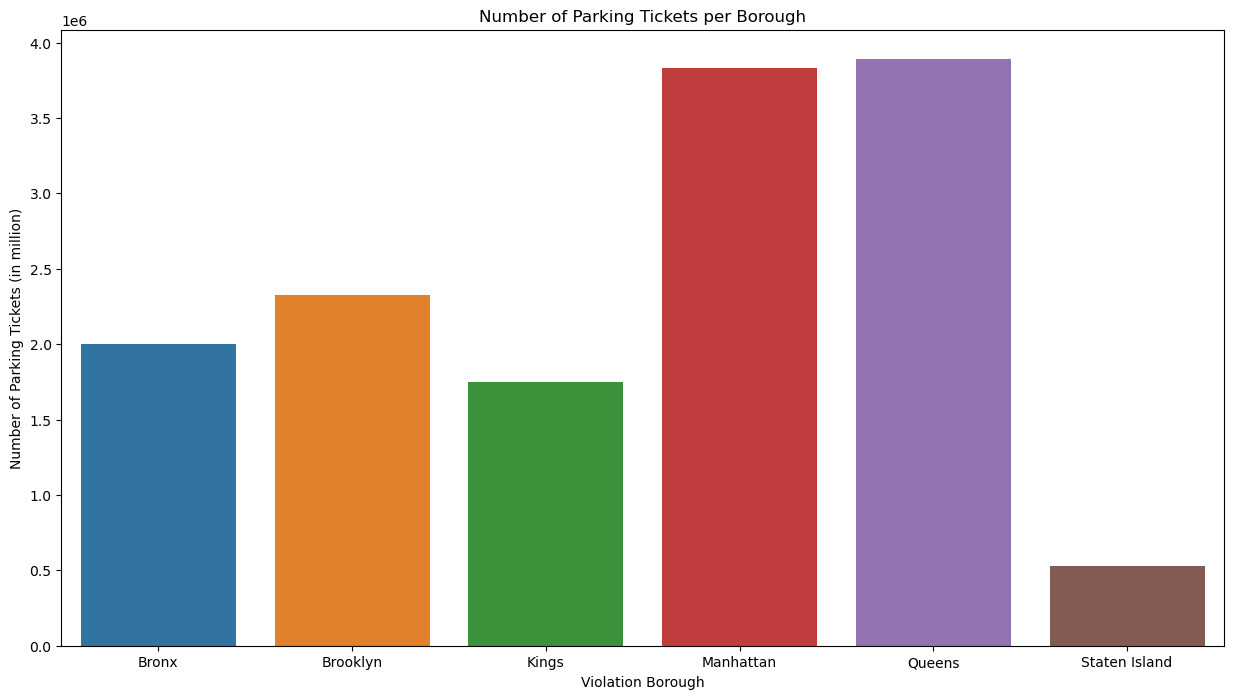

In [20]:

plt.figure(figsize=(15,8))
ax = sns.countplot(data=df, x='violation_county')
ax.set_title('Number of Parking Tickets per Borough')
ax.set_xlabel('Violation Borough')
ax.set_ylabel('Number of Parking Tickets (in million)')

plt.show()

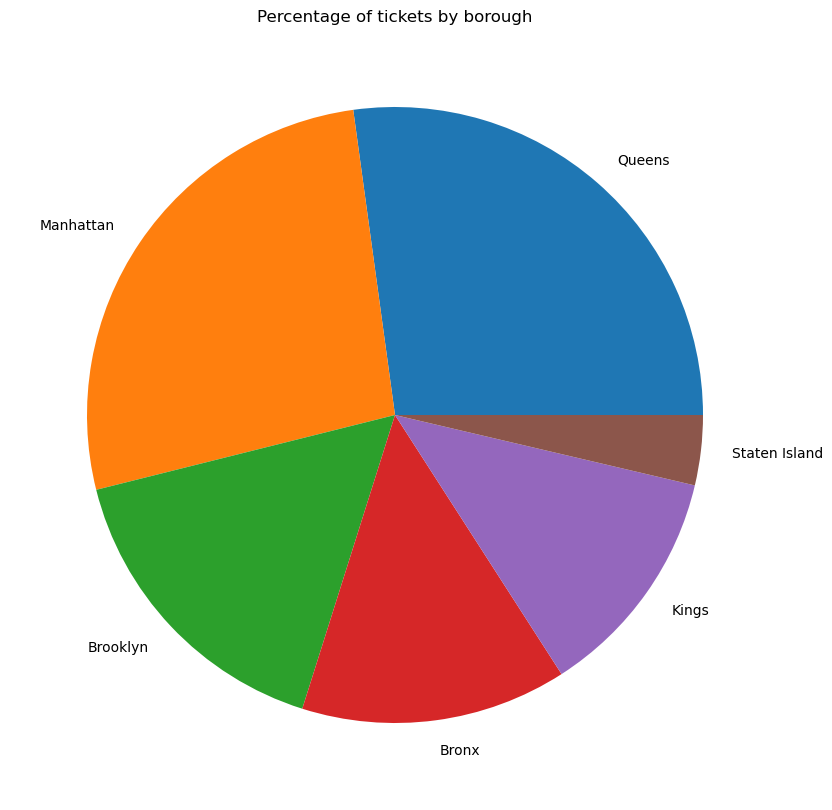

In [21]:
pie, ax = plt.subplots(figsize=[10,10])
plt.pie(x=borough_totals_df['count'], labels=borough_totals_df.index)
plt.title("Percentage of tickets by borough")
plt.show()

## Plot Monthly

In [22]:
from datetime import datetime

In [23]:
time_df = df[['issue_date', 'violation_county', 'violation_code']].copy()
time_df

,issue_date,violation_county,violation_code
0,2022-06-10,Manhattan,67
1,2022-06-13,Manhattan,51
2,2022-06-19,Manhattan,63
3,2022-06-19,Manhattan,63
4,2022-06-19,Manhattan,63
...,...,...,...
492957,2023-04-24,Manhattan,47
492958,2023-04-24,Manhattan,14
492959,2023-04-24,Manhattan,71
492960,2023-04-24,Manhattan,74


In [24]:
time_df['issue_date'].describe()

count                         14392670
mean     2022-11-20 11:26:06.236756480
min                1972-04-04 00:00:00
25%                2022-09-03 00:00:00
50%                2022-11-16 00:00:00
75%                2023-02-07 00:00:00
max                2066-06-24 00:00:00
Name: issue_date, dtype: object

In [25]:
time_df = time_df[(time_df['issue_date'] <= datetime(2023, 5, 16)) & (time_df['issue_date'] >= datetime(2022, 6, 1))]

In [26]:
time_df = time_df.set_index('issue_date', drop=True)

In [27]:
time_df = time_df.sort_index()

In [28]:
time_df

,violation_county,violation_code
issue_date,,
2022-06-01,Kings,14
2022-06-01,Kings,51
2022-06-01,Queens,20
2022-06-01,Manhattan,14
2022-06-01,Kings,10
...,...,...
2023-05-13,Queens,70
2023-05-14,Queens,14
2023-05-15,Kings,50


In [29]:
month_df = pd.DataFrame(time_df.resample('M').count()['violation_code']) 
month_df

,violation_code
issue_date,
2022-06-30,303854
2022-07-31,1354869
2022-08-31,1770741
2022-09-30,1491063
2022-10-31,1520707
2022-11-30,1453161
2022-12-31,1257973
2023-01-31,1346840
2023-02-28,1279847


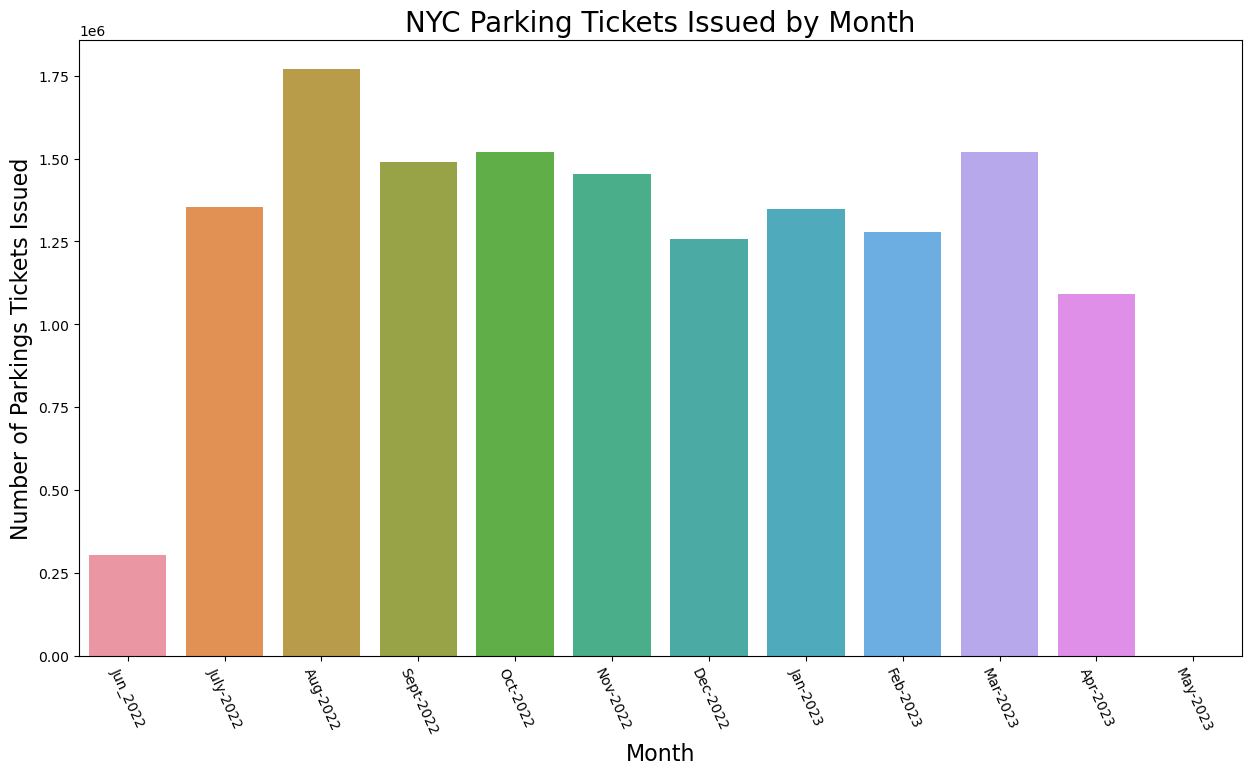

In [30]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=month_df, x=month_df.index, y='violation_code')
ax.set_xticklabels(labels= ['Jun_2022','July-2022', 'Aug-2022', 'Sept-2022','Oct-2022', 'Nov-2022', 'Dec-2022',
                             'Jan-2023','Feb-2023','Mar-2023','Apr-2023','May-2023'])
plt.xticks(rotation=-65)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of Parkings Tickets Issued', fontsize=16)
plt.title('NYC Parking Tickets Issued by Month', fontsize=20)
plt.show()

In [31]:
day_df = (time_df.groupby(by= time_df.index.floor('D')) 
                         .agg(number_of_tickets = ('violation_code', lambda x: x.count())))

In [32]:
day_df

,number_of_tickets
issue_date,
2022-06-01,68
2022-06-02,229
2022-06-03,175
2022-06-04,207
2022-06-05,1242
...,...
2023-05-11,13
2023-05-13,1
2023-05-14,1


In [33]:
day_df.index.day_of_week.unique()

Index([2, 3, 4, 5, 6, 0, 1], dtype='int32', name='issue_date')

Text(0.5, 1.0, 'Average tickets issued by day of the week')

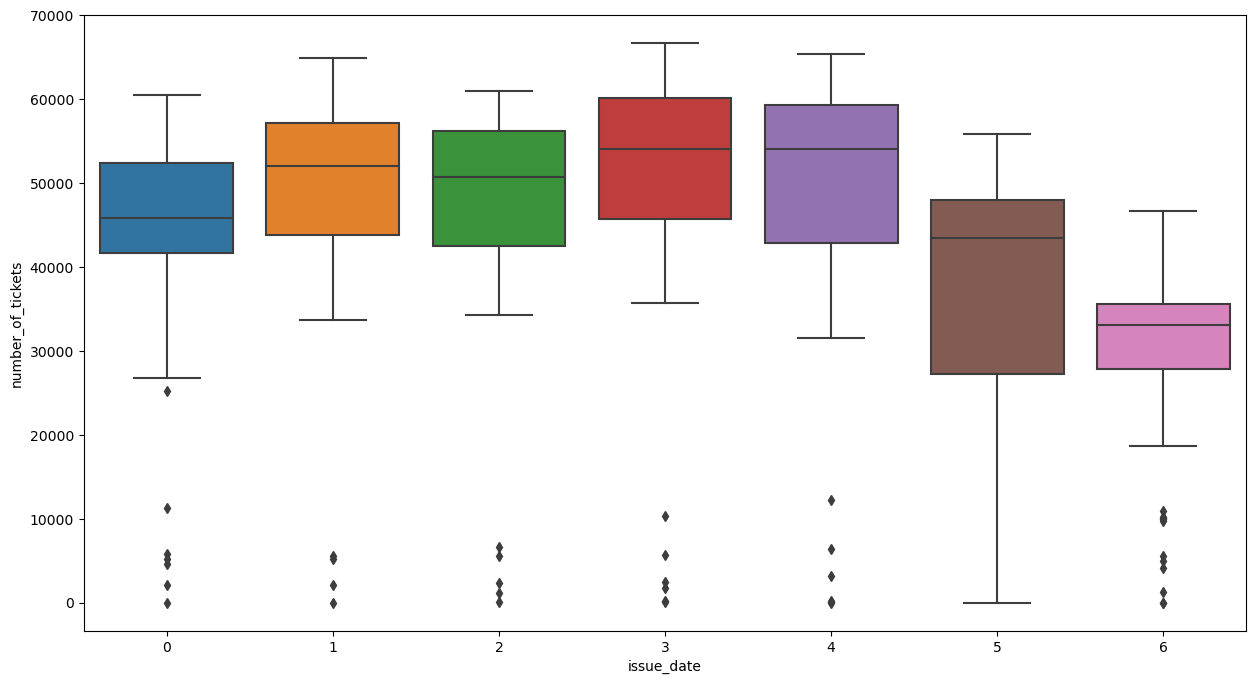

In [34]:
plt.figure(figsize=(15, 8))
x = sns.boxplot(x=day_df.index.dayofweek, y= 'number_of_tickets', data= day_df)
#ax.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], fontsize=14)
ax.set_xlabel('Day of the week', fontsize=16)
ax.set_ylabel('Number of tickets Issued', fontsize=16)
ax.set_title('Average tickets issued by day of the week', fontsize=20)

In [35]:
df.head()

,registration_state,plate_type,issue_date,violation_time,violation_location,issuer_precinct,issuer_code,violation_code,meter_number,violation_county,issuer_squad,issuing_agency,vehicle_make,street_name
0,NY,PAS,2022-06-10,1037A,0010,1,160195,67,-,Manhattan,0000,P,TOYOT,W 28TH ST
1,NY,PAS,2022-06-13,1045A,0010,1,160195,51,-,Manhattan,0000,K,JEEP,27TH DR
2,NJ,PAS,2022-06-19,1116A,0001,1,161315,63,-,Manhattan,0000,N,JEEP,SOUTH ST
3,NY,PAS,2022-06-19,1052A,0001,1,161315,63,-,Manhattan,0000,N,LEXUS,SOUTH ST
4,NJ,PAS,2022-06-19,1107A,0001,1,161315,63,-,Manhattan,0000,N,HYUND,SOUTH ST


In [37]:
# Streets with the most parking violations
top_streets = df[['violation_time','street_name']].groupby(['street_name']).count().sort_values(by='violation_time',ascending=False)
top_streets.head(10)

,violation_time
street_name,
Broadway,153326
WB N CONDUIT AVE @ S,119583
3rd Ave,114437
WB N. CONDUIT BLVD @,85067
5th Ave,81341
2nd Ave,69089
NB CROSS BAY BLVD @,67224
EB BRUCKNER BLVD @ W,66301
Madison Ave,65762


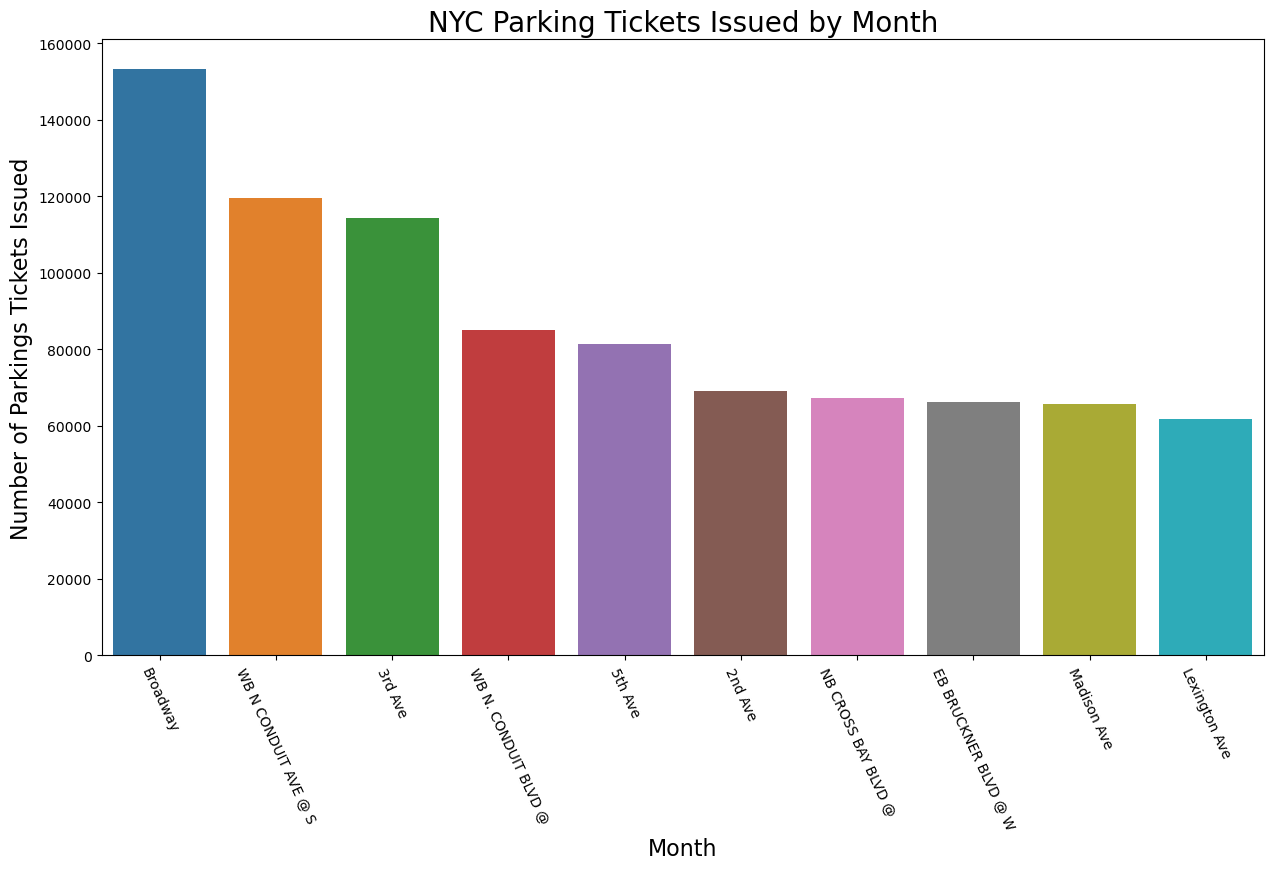

In [38]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=top_streets.head(10), x=top_streets.head(10).index, y='violation_time')
plt.xticks(rotation=-65)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of Parkings Tickets Issued', fontsize=16)
plt.title('NYC Parking Tickets Issued by Month', fontsize=20)
plt.show()

In [41]:
# Car manufacture
top_make= df[['violation_time','vehicle_make']].groupby(['vehicle_make']).count().sort_values(by='violation_time',ascending=False)
top_make.head(10)

,violation_time
vehicle_make,
HONDA,1736227
TOYOT,1658841
FORD,1314839
NISSA,1184544
CHEVR,764109
ME/BE,740051
BMW,723322
JEEP,663037
HYUND,489211
